In [1]:
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import codecs
import json
import itertools
import csv
import math
import matplotlib.pyplot as plt
import string

def read_dataset(path):
  with codecs.open(path, 'r', 'utf-8') as myFile:
    content = myFile.read()
  dataset = json.loads(content)
  return dataset

path = 'data/raw_data.json'
dataset = read_dataset(path)

print 'The dataset contains %d samples.' %(len(dataset))
print 'Available attributes: ', sorted(dataset[0].keys())
print 'First post:'
print json.dumps(dataset[0], sort_keys=True, indent=2)

successes = [r['requester_received_pizza'] for r in dataset]
success_rate = 100.0 * sum(successes) / float(len(successes))
print 'The average success rate is: %.2f%%' %(success_rate)


The dataset contains 5671 samples.
Available attributes:  [u'giver_username_if_known', u'in_test_set', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'request_text', u'request_text_edit_aware', u'request_title', u'requester_account_age_in_days_at_request', u'requester_account_age_in_days_at_retrieval', u'requester_days_since_first_post_on_raop_at_request', u'requester_days_since_first_post_on_raop_at_retrieval', u'requester_number_of_comments_at_request', u'requester_number_of_comments_at_retrieval', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_comments_in_raop_at_retrieval', u'requester_number_of_posts_at_request', u'requester_number_of_posts_at_retrieval', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_posts_on_raop_at_retrieval', u'requester_number_of_subreddits_at_request', u'requester_received_pizza', u'

In [2]:
#read train data
def create_data_sets(dataset):
    
    train = []
    cv = []
    test = []
    current = 0
    
    shuffle = np.random.permutation(np.arange(len(dataset)))
    
    train_range = int(round(len(shuffle) * 0.6))
    cv_range = int(round(len(shuffle) * 0.2))
    test_range = len(dataset) - train_range - cv_range
    
    for i in range(train_range):
        train.append(dataset[shuffle[current]])
        current += 1

    for i in range(cv_range):
        cv.append(dataset[shuffle[current]])
        current += 1

    for i in range(test_range):
        test.append(dataset[shuffle[current]])
        current += 1

    train_labels = np.zeros(len(train))
    cv_labels = np.zeros(len(cv))
    test_labels = np.zeros(len(test))

    train_data_text = []
    cv_data_text = []
    test_data_text = []

    for i in range(len(train_labels)):
        train_labels[i] = train[i].get('requester_received_pizza')

    for i in range(len(cv_labels)):
        cv_labels[i] = cv[i].get('requester_received_pizza')

    for i in range(len(test_labels)):
        test_labels[i] = test[i].get('requester_received_pizza')

    return train, train_labels, cv, cv_labels, test, test_labels

train, train_labels, cv, cv_labels, test, test_labels = create_data_sets(dataset)

In [3]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
def better_preprocessor(s):
### STUDENT START ###
    
    #LOWERCASE
    s = s.lower()
    
    #REMOVE PUNCTUATION
    s = s.replace("!","")
    s = s.replace(",","")
    s = s.replace("?","")
    s = s.replace(".","")
    s = s.replace("\'","")
    s = s.replace("-","")
    s = s.replace("_","")
    s = s.replace("*","")
    s = s.replace("&","")
    s = s.replace("$","")
    s = s.replace("#","")
    s = s.replace("~","")
    s = s.replace("\\","")
    s = s.replace("/","")
    s = s.replace("+","")
    s = s.replace("=","")
    s = s.replace("<","")
    s = s.replace(">","")
    s = s.replace(";","")
    s = s.replace(":","")
    s = s.replace("\"","")
    
    #change any number to the $ symbol
    s = s.replace("0","$")
    s = s.replace("1","$")
    s = s.replace("2","$")
    s = s.replace("3","$")
    s = s.replace("4","$")
    s = s.replace("5","$")
    s = s.replace("6","$")
    s = s.replace("7","$")
    s = s.replace("8","$")
    s = s.replace("9","$")
    
    #rescan tmp and change sequences of $$ into a single $
    while(s.find("$$") != -1):
        s = s.replace("$$","$")
        
    return s

Finding the optimal model fails for the most part because best is determined by score which isn't the F1Score :(

In [4]:
LR_train = LogisticRegression()
LR_train.fit(train_data_text,train_labels)

test_pred = LR_train.predict(test_data_text)

print(classification_report(test_labels, test_pred))


NameError: name 'train_data_text' is not defined

In [5]:
#create upsample for the positive case

def upsample_50_50(dataset, train_labels, cv_labels, test_labels):
    
    class_ratio = 1 / ((sum(train_labels) + sum(cv_labels) +sum(test_labels)) / len(dataset))
    
    minority_count = ((sum(train_labels) + sum(cv_labels) +sum(test_labels)))
    minority_goal = minority_count * (class_ratio - 1)
    
    upsampled_dataset = list(dataset)
                      
    while minority_count < minority_goal:
        index = int(round(np.random.rand()*len(dataset))) - 1
        
        if dataset[index].get('requester_received_pizza') == 1:
            upsampled_dataset.append(dataset[index])
            minority_count += 1
        
    return upsampled_dataset
                      
upsampled_dataset = upsample_50_50(dataset, train_labels, cv_labels, test_labels)

train_up, train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels = create_data_sets(upsampled_dataset)


In [6]:
import string

def make_subreddits_matrix(upsampled_dataset, train_up, cv_up, test_up):
    total_data_text = []
    train_data_text = []
    cv_data_text = []
    test_data_text = []

    feature = 'requester_subreddits_at_request'
    
    for i in range(len(upsampled_dataset)):
        total_data_text.append(string.join(upsampled_dataset[i].get(feature)," "))

    for i in range(len(train_up)):
        train_data_text.append(string.join(train_up[i].get(feature)," "))

    for i in range(len(cv_up)):
        cv_data_text.append(string.join(cv_up[i].get(feature)," "))

    for i in range(len(test_up)):
        test_data_text.append(string.join(test_up[i].get(feature)," "))

    vec_total = CountVectorizer(preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
    tokenized_total_data = vec_total.fit_transform(train_data_text)

    vec_train = CountVectorizer(vocabulary=vec_total.vocabulary_,preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
    tokenized_train_data = vec_train.fit_transform(train_data_text)

    vec_cv = CountVectorizer(vocabulary=vec_total.vocabulary_,preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
    tokenized_cv_data = vec_cv.fit_transform(cv_data_text)

    vec_test = CountVectorizer(vocabulary=vec_total.vocabulary_,preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
    tokenized_test_data = vec_test.fit_transform(test_data_text)
    
    return vec_total.vocabulary_, tokenized_train_data.todense(), tokenized_cv_data.todense(), tokenized_test_data.todense()

vocab_sr, train_data_text_sr, cv_data_text_sr, test_data_text_sr = make_subreddits_matrix(
                                                                    upsampled_dataset, train_up, cv_up, test_up)


For feature request_text_edit_aware



The stats for C=0.25
(1, 12485)
L2 Total :12485
L2 Number non-zero :12485
L2 Number features with all zero :0
(1, 12485)
L1 Total :12485
L1 Number non-zero :522
L1 Number features with all zero :11963
             precision    recall  f1-score   support

        0.0       0.64      0.68      0.66       840
        1.0       0.67      0.63      0.65       870

avg / total       0.66      0.66      0.66      1710


The stats for C=0.5
(1, 12485)
L2 Total :12485
L2 Number non-zero :12485
L2 Number features with all zero :0
(1, 12485)
L1 Total :12485
L1 Number non-zero :964
L1 Number features with all zero :11521
             precision    recall  f1-score   support

        0.0       0.68      0.68      0.68       840
        1.0       0.69      0.69      0.69       870

avg / total       0.69      0.69      0.69      1710


The stats for C=1
(1, 12485)
L2 Total :12485
L2 Number non-zero :12485
L2 Number features with all zero :0
(1, 12485)
L1 Total :

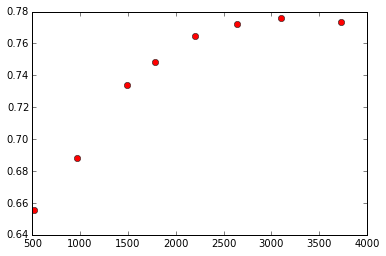

For feature request_title



The stats for C=0.25
(1, 4450)
L2 Total :4450
L2 Number non-zero :4450
L2 Number features with all zero :0
(1, 4450)
L1 Total :4450
L1 Number non-zero :206
L1 Number features with all zero :4244
             precision    recall  f1-score   support

        0.0       0.59      0.65      0.62       840
        1.0       0.63      0.57      0.60       870

avg / total       0.61      0.61      0.61      1710


The stats for C=0.5
(1, 4450)
L2 Total :4450
L2 Number non-zero :4450
L2 Number features with all zero :0
(1, 4450)
L1 Total :4450
L1 Number non-zero :474
L1 Number features with all zero :3976
             precision    recall  f1-score   support

        0.0       0.61      0.67      0.64       840
        1.0       0.65      0.59      0.62       870

avg / total       0.63      0.63      0.63      1710


The stats for C=1
(1, 4450)
L2 Total :4450
L2 Number non-zero :4450
L2 Number features with all zero :0
(1, 4450)
L1 Total :4450
L1 Number non-zero :9

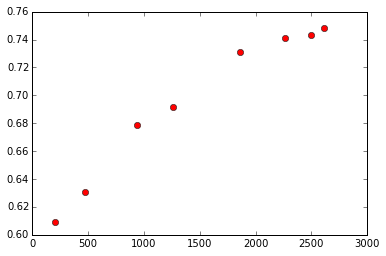

For feature requester_subreddits_at_request



The stats for C=0.25
(1, 7059)
L2 Total :7059
L2 Number non-zero :7059
L2 Number features with all zero :0
(1, 7059)
L1 Total :7059
L1 Number non-zero :232
L1 Number features with all zero :6827
             precision    recall  f1-score   support

        0.0       0.58      0.69      0.63       840
        1.0       0.63      0.51      0.56       870

avg / total       0.60      0.60      0.59      1710


The stats for C=0.5
(1, 7059)
L2 Total :7059
L2 Number non-zero :7059
L2 Number features with all zero :0
(1, 7059)
L1 Total :7059
L1 Number non-zero :489
L1 Number features with all zero :6570
             precision    recall  f1-score   support

        0.0       0.61      0.72      0.66       840
        1.0       0.68      0.56      0.61       870

avg / total       0.65      0.64      0.64      1710


The stats for C=1
(1, 7059)
L2 Total :7059
L2 Number non-zero :7059
L2 Number features with all zero :0
(1, 7059)
L1 Total :7059
L1 

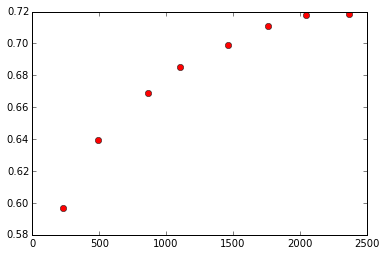

In [7]:
def L1PruneText(train, train_labels, cv, cv_labels, feature):
   
    C_val = [0.25, 0.5, 1, 1.5, 3, 6,12, 24]
    accuracy = []  #store accuracies for plotting
    NNZ_array = [] #store non-zero for plotting
    
    train_data_text = []
    cv_data_text = []
    
    Valuable_Vocab_List = []

    print "For feature " + feature + "\n\n"
    
    if feature == 'requester_subreddits_at_request':
        for i in range(len(train_up)):
            train_data_text.append(string.join(train_up[i].get(feature)," "))

        for i in range(len(cv_up)):
            cv_data_text.append(string.join(cv_up[i].get(feature)," "))

    else:
        for i in range(len(train)):
            train_data_text.append(train[i].get(feature))

        for i in range(len(cv)):
            cv_data_text.append(cv[i].get(feature))
    
    #Iterate through various C_val parameters for L2 and L1 norms
    
    for iter in range(len(C_val)):

        print "\nThe stats for C=" + str(C_val[iter])
        
        ############### L2 NORM COMPUTATION #####################
        countVecPreProc = CountVectorizer(preprocessor=better_preprocessor)
        DocMatrixPreProc = countVecPreProc.fit_transform(train_data_text)
        LRPreProcL2 = LogisticRegression(C=C_val[iter],penalty='l2',tol = 0.01)
        LRPreProcL2.fit(DocMatrixPreProc,train_labels)

        numNonZero = 0  #sum of nonzero parameters for all classes
        allZero = 0     #all are 0 for this feature for all classes
        total_param = 0       #number of parameters

        print LRPreProcL2.coef_.shape

        for i in range(LRPreProcL2.coef_.shape[0]):
            for j in range(LRPreProcL2.coef_.shape[1]):
                total_param = total_param + 1
                if(LRPreProcL2.coef_[i,j]!=0):
                    numNonZero = numNonZero + 1

                #see if all of this feature are 0
                if((LRPreProcL2.coef_[0,j] == 0)):
                    allZero = allZero + 1

        print "L2 Total :" + str(total_param)
        print "L2 Number non-zero :" + str(numNonZero)
        print "L2 Number features with all zero :" + str(allZero)

        ############### L1 NORM COMPUTATION #####################
        countVecPreProc = CountVectorizer(preprocessor=better_preprocessor)
        DocMatrixPreProc = countVecPreProc.fit_transform(train_data_text)
        LRPreProcL1 = LogisticRegression(C=C_val[iter],penalty='l1',tol = 0.01)
        LRPreProcL1.fit(DocMatrixPreProc,train_labels)

        numNonZero = 0  #sum of nonzero parameters for all classes
        allZero = 0     #all are 0 for this feature for all classes
        total_param = 0       #number of parameters
        ValuableIndices = [] #track features that have at least one class with a non zero weight

        print LRPreProcL1.coef_.shape

        for i in range(LRPreProcL1.coef_.shape[0]):
            for j in range(LRPreProcL1.coef_.shape[1]):
                total_param = total_param + 1
                if(LRPreProcL1.coef_[i,j]!=0):
                    numNonZero = numNonZero + 1

                #see if all of this feature are 0
                if((LRPreProcL1.coef_[0,j] == 0)):
                    allZero = allZero + 1
                else:
                    ValuableIndices.append(j)

        print "L1 Total :" + str(total_param)
        print "L1 Number non-zero :" + str(numNonZero)
        print "L1 Number features with all zero :" + str(allZero)
        
        ############### FILTER USING L1 WEIGHTS #####################
        #get valuable vocab using the criteria L1 weight > 0

        ValuableVocab = []

        for i in range(LRPreProcL1.coef_.shape[1]):
            if i in ValuableIndices:
                ValuableVocab.append(countVecPreProc.get_feature_names()[i])

        #Trim vocab to just valuable features
        countVecL1Trim = CountVectorizer(vocabulary = ValuableVocab, preprocessor=better_preprocessor)
        DocMatrixL1Trim = countVecL1Trim.fit_transform(train_data_text)
        LRL1TrimL2Train = LogisticRegression(C=C_val[iter],penalty='l2',tol = 0.01)
        LRL1TrimL2Train.fit(DocMatrixL1Trim,train_labels)


        #make sure we use the vocab from the train data
        countVecDevL1Trim = CountVectorizer(vocabulary = ValuableVocab, preprocessor=better_preprocessor)
        DocMatrixDevL1Trim = countVecDevL1Trim.fit_transform(cv_data_text)
        cv_pred_LR_L1TrimL2Train = LRL1TrimL2Train.predict(DocMatrixDevL1Trim)


        print(classification_report(cv_labels, cv_pred_LR_L1TrimL2Train))
        accuracy.append(LRL1TrimL2Train.score(DocMatrixDevL1Trim,cv_labels))
        NNZ_array.append(numNonZero)
    
        Valuable_Vocab_List.append(ValuableVocab)
    
    plt.plot(NNZ_array,accuracy,'ro')
    plt.show()
    
    return Valuable_Vocab_List

feature = 'request_text_edit_aware'

ValuableVocab_Text = L1PruneText(train_up, train_up_labels, cv_up, cv_up_labels, feature)

feature = 'request_title'

ValuableVocab_Title = L1PruneText(train_up, train_up_labels, cv_up, cv_up_labels, feature)

feature = 'requester_subreddits_at_request'

ValuableVocab_Subreddits = L1PruneText(train_up, train_up_labels, cv_up, cv_up_labels, feature)

def L1PruneLemmaText(train, train_labels, cv, cv_labels, feature):
   
    C_val = [0.25, 0.5, 1, 1.5, 3, 6]
    accuracy = []  #store accuracies for plotting
    NNZ_array = [] #store non-zero for plotting
    
    train_data_text = []
    cv_data_text = []
    
    Valuable_Vocab_List = []

    print "For feature " + feature + "\n\n"
    
    if feature == 'requester_subreddits_at_request':
        for i in range(len(train_up)):
            train_data_text.append(string.join(train_up[i].get(feature)," "))

        for i in range(len(cv_up)):
            cv_data_text.append(string.join(cv_up[i].get(feature)," "))

    else:
        for i in range(len(train)):
            train_data_text.append(train[i].get(feature))

        for i in range(len(cv)):
            cv_data_text.append(cv[i].get(feature))
    
    #Iterate through various C_val parameters for L2 and L1 norms
    
    for iter in range(len(C_val)):

        print "\nThe stats for C=" + str(C_val[iter])
        
        ############### L2 NORM COMPUTATION #####################
        countVecPreProc = CountVectorizer(preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
        DocMatrixPreProc = countVecPreProc.fit_transform(train_data_text)
        LRPreProcL2 = LogisticRegression(C=C_val[iter],penalty='l2',tol = 0.01)
        LRPreProcL2.fit(DocMatrixPreProc,train_labels)

        numNonZero = 0  #sum of nonzero parameters for all classes
        allZero = 0     #all are 0 for this feature for all classes
        total_param = 0       #number of parameters

        print LRPreProcL2.coef_.shape

        for i in range(LRPreProcL2.coef_.shape[0]):
            for j in range(LRPreProcL2.coef_.shape[1]):
                total_param = total_param + 1
                if(LRPreProcL2.coef_[i,j]!=0):
                    numNonZero = numNonZero + 1

                #see if all of this feature are 0
                if((LRPreProcL2.coef_[0,j] == 0)):
                    allZero = allZero + 1

        print "L2 Total :" + str(total_param)
        print "L2 Number non-zero :" + str(numNonZero)
        print "L2 Number features with all zero :" + str(allZero)

        ############### L1 NORM COMPUTATION #####################
        countVecPreProc = CountVectorizer(preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
        DocMatrixPreProc = countVecPreProc.fit_transform(train_data_text)
        LRPreProcL1 = LogisticRegression(C=C_val[iter],penalty='l1',tol = 0.01)
        LRPreProcL1.fit(DocMatrixPreProc,train_labels)

        numNonZero = 0  #sum of nonzero parameters for all classes
        allZero = 0     #all are 0 for this feature for all classes
        total_param = 0       #number of parameters
        ValuableIndices = [] #track features that have at least one class with a non zero weight

        print LRPreProcL1.coef_.shape

        for i in range(LRPreProcL1.coef_.shape[0]):
            for j in range(LRPreProcL1.coef_.shape[1]):
                total_param = total_param + 1
                if(LRPreProcL1.coef_[i,j]!=0):
                    numNonZero = numNonZero + 1

                #see if all of this feature are 0
                if((LRPreProcL1.coef_[0,j] == 0)):
                    allZero = allZero + 1
                else:
                    ValuableIndices.append(j)

        print "L1 Total :" + str(total_param)
        print "L1 Number non-zero :" + str(numNonZero)
        print "L1 Number features with all zero :" + str(allZero)
        
        ############### FILTER USING L1 WEIGHTS #####################
        #get valuable vocab using the criteria L1 weight > 0

        ValuableVocab = []

        for i in range(LRPreProcL1.coef_.shape[1]):
            if i in ValuableIndices:
                ValuableVocab.append(countVecPreProc.get_feature_names()[i])

        #Trim vocab to just valuable features
        countVecL1Trim = CountVectorizer(vocabulary = ValuableVocab, preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
        DocMatrixL1Trim = countVecL1Trim.fit_transform(train_data_text)
        LRL1TrimL2Train = LogisticRegression(C=C_val[iter],penalty='l2',tol = 0.01)
        LRL1TrimL2Train.fit(DocMatrixL1Trim,train_labels)


        #make sure we use the vocab from the train data
        countVecDevL1Trim = CountVectorizer(vocabulary = ValuableVocab, preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
        DocMatrixDevL1Trim = countVecDevL1Trim.fit_transform(cv_data_text)
        cv_pred_LR_L1TrimL2Train = LRL1TrimL2Train.predict(DocMatrixDevL1Trim)


        print(classification_report(cv_labels, cv_pred_LR_L1TrimL2Train))
        accuracy.append(LRL1TrimL2Train.score(DocMatrixDevL1Trim,cv_labels))
        NNZ_array.append(numNonZero)
    
        Valuable_Vocab_List.append(ValuableVocab)
    
    plt.plot(NNZ_array,accuracy,'ro')
    plt.show()
    
    return Valuable_Vocab_List

feature = 'request_text_edit_aware'

LemmaVocab_Text = L1PruneLemmaText(train_up, train_up_labels, cv_up, cv_up_labels, feature)

feature = 'request_title'

LemmaVocab_Title = L1PruneLemmaText(train_up, train_up_labels, cv_up, cv_up_labels, feature)

feature = 'requester_subreddits_at_request'

LemmaVocab_Subreddits = L1PruneLemmaText(train_up, train_up_labels, cv_up, cv_up_labels, feature)

In [8]:
def find_optim_model_textual(train, train_labels, cv, cv_labels, test, test_labels, feature, vocab):
    #print out the before and after with the new feature, and
    #confirm that it isn't overfit via cv and test compare
    
    #return the new train_data cv_data and test_data
    
    train_data_text = []
    cv_data_text = []
    test_data_text = []
    
    if feature == 'requester_subreddits_at_request':
        for i in range(len(train_labels)):
            train_data_text.append(string.join(train_up[i].get(feature)," "))
        for i in range(len(cv_labels)):
            cv_data_text.append(string.join(cv_up[i].get(feature)," "))
        for i in range(len(test_labels)):
            test_data_text.append(string.join(test_up[i].get(feature)," "))
    else:
        for i in range(len(train_labels)):
            train_data_text.append(train[i].get(feature))

        for i in range(len(cv_labels)):
            cv_data_text.append(cv[i].get(feature))

        for i in range(len(test_labels)):
            test_data_text.append(test[i].get(feature))
            
    accuracy_LR = []
    accuracy_BNB = []
    accuracy_KNN = []
    accuracy_DT = []
    numVocab = []
    
    for j in range(len(vocab)):
        numVocab.append(len(vocab[j]))
        
    for j in range(len(vocab)):
        vec_train = CountVectorizer(vocabulary=vocab[j],preprocessor=better_preprocessor)
        tokenized_train_data = vec_train.fit_transform(train_data_text)

        vec_cv = CountVectorizer(vocabulary=vocab[j],preprocessor=better_preprocessor)
        tokenized_cv_data = vec_cv.fit_transform(cv_data_text)

        vec_test = CountVectorizer(vocabulary=vocab[j],preprocessor=better_preprocessor)
        tokenized_test_data = vec_test.fit_transform(test_data_text)

        #find optimal C
        C_val = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 16]
        #C_val = [1,2]
        
        best_C_LR = 0
        best_C_BNB = 0
        best_C_KNN = 0
        best_C_DT = 0

        for i in range(len(C_val)):

            #Logistic Regression section
            LR_train = LogisticRegression(C=C_val[i])
            LR_train.fit(tokenized_train_data,train_labels)

            cv_pred = LR_train.predict(tokenized_cv_data)

            print "\nThe cv stats for LR with C=" + str(C_val[i])

            print(classification_report(cv_labels, cv_pred))

            test_pred = LR_train.predict(tokenized_test_data)
            print "The test results are:\n"
            print(classification_report(test_labels, test_pred))
            
            tmp = LR_train.score(tokenized_test_data,test_labels)
            if tmp > best_C_LR:
                best_C_LR = tmp

            #Bernoulli Naive Bayes section
            if C_val[i] <= 1:
                BNB_train = BernoulliNB(alpha=C_val[i])
                BNB_train.fit(tokenized_train_data,train_labels)

                cv_pred = BNB_train.predict(tokenized_cv_data)

                print "\nThe cv stats for BNB with alpha=" + str(C_val[i])

                print(classification_report(cv_labels, cv_pred))

                test_pred = BNB_train.predict(tokenized_test_data)
                print "The test results are:\n"
                print(classification_report(test_labels, test_pred))
                
                tmp = BNB_train.score(tokenized_test_data,test_labels)
                if tmp > best_C_BNB:
                    best_C_BNB = tmp

            #KNN section
            if C_val[i] >= 1:
                KNN_train = KNeighborsClassifier(n_neighbors=int(C_val[i]))
                KNN_train.fit(tokenized_train_data,train_labels)

                cv_pred = KNN_train.predict(tokenized_cv_data)

                print "\nThe cv stats for KNN with n_neighbors=" + str(int(math.ceil(C_val[i] * 2)))

                print(classification_report(cv_labels, cv_pred))

                test_pred = KNN_train.predict(tokenized_test_data)
                print "The test results are:\n"
                print(classification_report(test_labels, test_pred))

                tmp = KNN_train.score(tokenized_test_data,test_labels)
                if tmp > best_C_KNN:
                    best_C_KNN = tmp

            #DT section
            if C_val[i] >= 1:
                clf = DecisionTreeClassifier(max_depth=int(C_val[i]))
                clf.fit(tokenized_train_data,train_labels)

                cv_pred = clf.predict(tokenized_cv_data)

                print "\nFor DT cv :\n"
                print(classification_report(cv_labels, cv_pred))

                test_pred = clf.predict(tokenized_test_data)

                print "The test results are:\n"
                print(classification_report(test_labels, test_pred))

                tmp = clf.score(tokenized_test_data,test_labels)
                if tmp > best_C_DT:
                    best_C_DT = tmp
                    
        
        accuracy_LR.append(best_C_LR)
        accuracy_BNB.append(best_C_BNB)
        accuracy_KNN.append(best_C_KNN)
        accuracy_DT.append(best_C_DT)
        
    plt.plot(numVocab,accuracy_LR,'y-')
    plt.plot(numVocab,accuracy_BNB,'b-')
    plt.plot(numVocab,accuracy_KNN,'g-')
    plt.plot(numVocab,accuracy_DT,'r-')
    plt.show()
    
    return tokenized_train_data.todense(), tokenized_cv_data.todense(), tokenized_test_data.todense()

In [9]:
def find_optim_model_numerical(train, train_labels, cv, cv_labels, test, test_labels):
    #print out the before and after with the new feature, and
    #confirm that it isn't overfit via cv and test compare
    
    #return the new train_data cv_data and test_data
            
    accuracy_LR = []
    config_LR = []
    accuracy_GNB = []
    config_GNB = []
    accuracy_KNN = []
    config_KNN = []
    accuracy_DT = []
    config_DT = []
    best_clf = []
    best_config = 0
    best_score = 0

    #find optimal C
    C_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 16]

    for i in range(len(C_val)):

        #Logistic Regression section
        LR_train = LogisticRegression(C=C_val[i])
        LR_train.fit(train,train_labels)

        cv_pred = LR_train.predict(cv)

        print "\nThe cv stats for LR with C=" + str(C_val[i])

        print(classification_report(cv_labels, cv_pred))

        test_pred = LR_train.predict(test)
        print "The test results are:\n"
        print(classification_report(test_labels, test_pred))

        accuracy_LR.append(LR_train.score(test,test_labels))
        config_LR.append(C_val[i])
        
        if best_score < LR_train.score(test,test_labels):
            best_clf = "LR"
            best_config = C_val[i]
            best_score = LR_train.score(test,test_labels)

        #Gaussian Naive Bayes section
        GNB_train = GaussianNB()
        GNB_train.fit(train,train_labels)

        cv_pred = GNB_train.predict(cv)

        print "\nThe cv stats for BNB with alpha=" + str(C_val[i])

        print(classification_report(cv_labels, cv_pred))

        test_pred = GNB_train.predict(test)
        print "The test results are:\n"
        print(classification_report(test_labels, test_pred))

        accuracy_GNB.append(GNB_train.score(test,test_labels))
        config_GNB.append(C_val[i])
        
        if best_score < GNB_train.score(test,test_labels):
            best_clf = "GNB"
            best_config = C_val[i]
            best_score = GNB_train.score(test,test_labels)

        #KNN section
        KNN_train = KNeighborsClassifier(n_neighbors=int(math.ceil(C_val[i] * 2)))
        KNN_train.fit(train,train_labels)

        cv_pred = KNN_train.predict(cv)

        print "\nThe cv stats for KNN with n_neighbors=" + str(int(math.ceil(C_val[i] * 2)))

        print(classification_report(cv_labels, cv_pred))

        test_pred = KNN_train.predict(test)
        print "The test results are:\n"
        print(classification_report(test_labels, test_pred))

        accuracy_KNN.append(KNN_train.score(test,test_labels))
        config_KNN.append(int(math.ceil(C_val[i] * 2)))
        
        if best_score < KNN_train.score(test,test_labels):
            best_clf = "KNN"
            best_config = int(math.ceil(C_val[i] * 2))
            best_score = KNN_train.score(test,test_labels)
            
        #DT section
        clf = DecisionTreeClassifier(max_depth=int(math.ceil(C_val[i] * 2)))
        clf.fit(train,train_labels)

        cv_pred = clf.predict(cv)

        print "\nFor DT cv with max depth :\n"  + str(int(math.ceil(C_val[i] * 2)))
        print(classification_report(cv_labels, cv_pred))

        test_pred = clf.predict(test)

        print "The test results are:\n"
        print(classification_report(test_labels, test_pred))

        accuracy_DT.append(clf.score(test,test_labels))
        config_DT.append(int(math.ceil(C_val[i] * 2)))
        
        if best_score < clf.score(test,test_labels):
            best_clf = "DT"
            best_config = int(math.ceil(C_val[i] * 2))
            best_score = clf.score(test,test_labels)
        
    plt.plot(config_LR,accuracy_LR,'y-')
    plt.plot(config_GNB,accuracy_GNB,'b-')
    plt.plot(config_KNN,accuracy_KNN,'g-')
    plt.plot(config_DT,accuracy_DT,'r-')
    plt.show()
    
    return best_clf, best_config, best_score

requester_subreddits_at_request


The cv stats for LR with C=0.001
             precision    recall  f1-score   support

        0.0       0.56      0.45      0.50       840
        1.0       0.55      0.65      0.60       870

avg / total       0.55      0.55      0.55      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.58      0.47      0.52       862
        1.0       0.55      0.65      0.59       847

avg / total       0.56      0.56      0.56      1709


The cv stats for BNB with alpha=0.001
             precision    recall  f1-score   support

        0.0       0.53      0.65      0.58       840
        1.0       0.57      0.45      0.50       870

avg / total       0.55      0.55      0.54      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.56      0.67      0.61       862
        1.0       0.58      0.47      0.52       847

avg / total       0.57      0.57      0.57

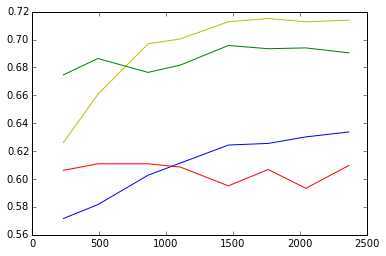

In [10]:
feature = 'requester_subreddits_at_request'
print feature + "\n"
train_data_sr, cv_data_sr, test_data_sr = find_optim_model_textual(train_up, 
                    train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels, feature,ValuableVocab_Subreddits)

request_text_edit_aware


The cv stats for LR with C=0.001
             precision    recall  f1-score   support

        0.0       0.60      0.50      0.55       840
        1.0       0.58      0.67      0.63       870

avg / total       0.59      0.59      0.59      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.62      0.52      0.57       862
        1.0       0.58      0.67      0.62       847

avg / total       0.60      0.60      0.59      1709


The cv stats for BNB with alpha=0.001
             precision    recall  f1-score   support

        0.0       0.59      0.62      0.61       840
        1.0       0.61      0.58      0.59       870

avg / total       0.60      0.60      0.60      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.59      0.63      0.61       862
        1.0       0.59      0.55      0.57       847

avg / total       0.59      0.59      0.59      17

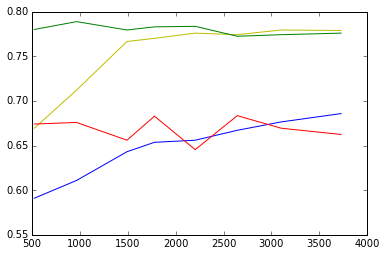

In [11]:
feature = 'request_text_edit_aware'
print feature + "\n"
train_data_text, cv_data_text, test_data_text = find_optim_model_textual(train_up, 
                    train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels, feature,ValuableVocab_Text)

request_title


The cv stats for LR with C=0.001
             precision    recall  f1-score   support

        0.0       0.55      0.55      0.55       840
        1.0       0.56      0.56      0.56       870

avg / total       0.55      0.55      0.55      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.55      0.51      0.53       862
        1.0       0.54      0.58      0.56       847

avg / total       0.55      0.55      0.55      1709


The cv stats for BNB with alpha=0.001
             precision    recall  f1-score   support

        0.0       0.59      0.67      0.63       840
        1.0       0.63      0.54      0.59       870

avg / total       0.61      0.61      0.61      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.58      0.65      0.61       862
        1.0       0.59      0.52      0.55       847

avg / total       0.58      0.58      0.58      1709


The c

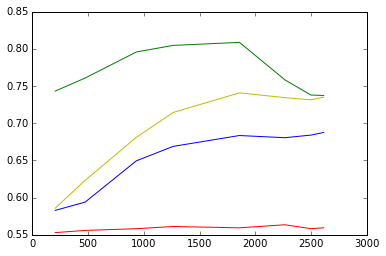

In [12]:
feature = 'request_title'
print feature + "\n"
train_data_title, cv_data_title, test_data_title = find_optim_model_textual(train_up, 
                    train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels, feature,ValuableVocab_Title)

From the information above, we conclude that we should:

use KNN for the title with about 2000 features [5] with 2 neighbors
use KNN for the text with about 1500 features [2] with 2 neighbors
use LR for the subreddits with about the top 2000 [6] with C=8

optimal C for ensemble LR is 0.0001

best model is KNN with 16 neighbors

requester_number_of_comments_in_raop_at_request 
requester_number_of_comments_at_request
requester_number_of_posts_at_request
requester_number_of_posts_on_raop_at_request

are all correlated

Maybe engineer together (multiply)


The cv stats for LR with C=0.0001
             precision    recall  f1-score   support

        0.0       0.54      0.34      0.42       840
        1.0       0.53      0.72      0.61       870

avg / total       0.53      0.53      0.51      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.58      0.34      0.43       862
        1.0       0.53      0.75      0.62       847

avg / total       0.56      0.55      0.53      1709


The cv stats for BNB with alpha=0.0001
             precision    recall  f1-score   support

        0.0       0.51      0.90      0.65       840
        1.0       0.60      0.15      0.24       870

avg / total       0.55      0.52      0.44      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.51      0.87      0.65       862
        1.0       0.54      0.15      0.24       847

avg / total       0.53      0.52      0.44      1709


The cv stats for K

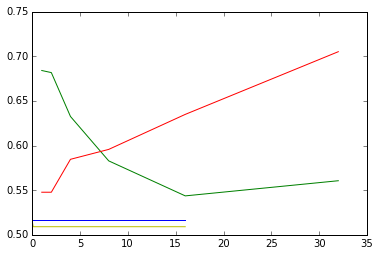

DT
32
0.705090696314


In [81]:
def evaluate_new_feature(train_data, train_labels, train_mat, cv_data, cv_labels, cv_mat, test_data, 
                         test_labels, test_mat, feature):

    train_temp = []
    cv_temp = []
    test_temp = []
    
    for i in range(len(train_labels)):
        train_temp.append((train_data[i].get(feature)))

    for i in range(len(cv_labels)):
        cv_temp.append((cv_data[i].get(feature)))

    for i in range(len(test_labels)):
        test_temp.append((test_data[i].get(feature)))
    
    train_mat_tmp = np.c_[train_mat,train_temp]
    cv_mat_tmp = np.c_[cv_mat,cv_temp]
    test_mat_tmp = np.c_[test_mat,test_temp]

    best_clf, best_config, best_score = find_optim_model_numerical(train_mat_tmp, 
                                train_labels, cv_mat_tmp, cv_labels, test_mat_tmp, test_labels)

    print best_clf
    print best_config
    print best_score
    
    return train_mat_tmp, cv_mat_tmp, test_mat_tmp

feature = 'requester_account_age_in_days_at_request'

train_age = []
cv_age = []
test_age = []

for i in range(len(train_up_labels)):
    train_age.append((train_up[i].get(feature)))

for i in range(len(cv_up_labels)):
    cv_age.append((cv_up[i].get(feature)))

for i in range(len(test_up_labels)):
    test_age.append((test_up[i].get(feature)))

feature = 'requester_days_since_first_post_on_raop_at_request'

train_data_plus, cv_data_plus, test_data_plus = evaluate_new_feature(train_up, 
                    train_up_labels, train_age, cv_up, cv_up_labels, cv_age, test_up, test_up_labels, test_age, feature)


requester_number_of_comments_at_request


The cv stats for LR with C=0.0001
             precision    recall  f1-score   support

        0.0       0.54      0.35      0.43       840
        1.0       0.53      0.71      0.61       870

avg / total       0.53      0.53      0.52      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.57      0.35      0.44       862
        1.0       0.53      0.73      0.61       847

avg / total       0.55      0.54      0.52      1709


The cv stats for BNB with alpha=0.0001
             precision    recall  f1-score   support

        0.0       0.50      0.86      0.64       840
        1.0       0.57      0.18      0.28       870

avg / total       0.54      0.52      0.45      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.50      0.82      0.63       862
        1.0       0.50      0.18      0.26       847

avg / total       0.50      0.50

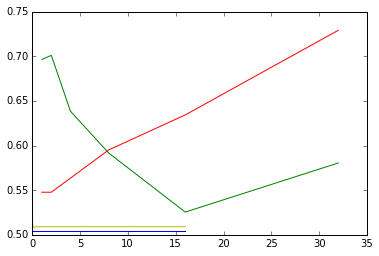

DT
32
0.729081334114


In [82]:
feature = 'requester_number_of_comments_at_request'
print feature + "\n"
train_data_plus_2, cv_data_plus_2, test_data_plus_2 = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature)

requester_upvotes_minus_downvotes_at_request


The cv stats for LR with C=0.0001
             precision    recall  f1-score   support

        0.0       0.54      0.40      0.46       840
        1.0       0.53      0.66      0.59       870

avg / total       0.54      0.54      0.53      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.57      0.41      0.48       862
        1.0       0.53      0.68      0.60       847

avg / total       0.55      0.54      0.54      1709


The cv stats for BNB with alpha=0.0001
             precision    recall  f1-score   support

        0.0       0.50      0.89      0.64       840
        1.0       0.59      0.15      0.24       870

avg / total       0.55      0.51      0.44      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.51      0.87      0.65       862
        1.0       0.55      0.16      0.25       847

avg / total       0.53     

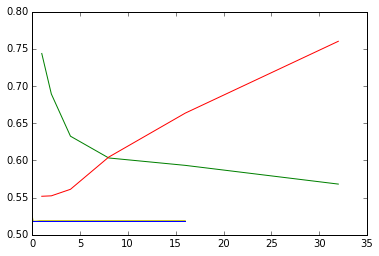

DT
32
0.760093622001


In [83]:
feature = 'requester_upvotes_minus_downvotes_at_request'
print feature + "\n"
train_data_plus_3, cv_data_plus_3, test_data_plus_3 = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus_2, cv_up, cv_up_labels, cv_data_plus_2, test_up, test_up_labels, test_data_plus_2, feature)



Ignore.  Passing timestamp as is did better

#engineer timestamp info

from datetime import datetime

train_ts = []
cv_ts = []
test_ts = []

feature = 'unix_timestamp_of_request'

for i in range(len(train_up_labels)):
    train_ts.append(int(datetime.fromtimestamp(train_up[i].get(feature)).hour))

for i in range(len(cv_up_labels)):
    cv_ts.append(int(datetime.fromtimestamp(cv_up[i].get(feature)).hour))

for i in range(len(test_up_labels)):
    test_ts.append(int(datetime.fromtimestamp(test_up[i].get(feature)).hour))

#print train_ts[0]
#print datetime.fromtimestamp(train_ts[0]).hour

train_data_plus_4 = np.c_[train_data_plus_3, train_ts]
cv_data_plus_4 = np.c_[cv_data_plus_3, cv_ts]
test_data_plus_4 = np.c_[test_data_plus_3, test_ts]

print feature + "\n"
train_data_plus_5, cv_data_plus_5, test_data_plus_5 = evaluate_new_feature(train_up, 
                   train_up_labels, train_data_plus_4, cv_up, cv_up_labels, cv_data_plus_4, test_up, test_up_labels, test_data_plus_4, feature)



requester_number_of_subreddits_at_request


The cv stats for LR with C=0.0001
             precision    recall  f1-score   support

        0.0       0.54      0.40      0.46       840
        1.0       0.53      0.67      0.59       870

avg / total       0.53      0.53      0.53      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.57      0.41      0.48       862
        1.0       0.53      0.68      0.60       847

avg / total       0.55      0.55      0.54      1709


The cv stats for BNB with alpha=0.0001
             precision    recall  f1-score   support

        0.0       0.50      0.88      0.64       840
        1.0       0.58      0.16      0.25       870

avg / total       0.54      0.51      0.44      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.51      0.86      0.64       862
        1.0       0.54      0.17      0.26       847

avg / total       0.53      0.

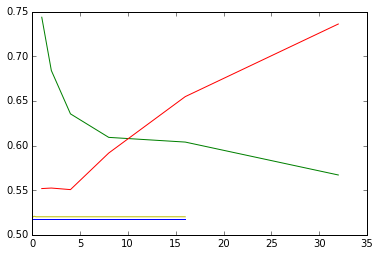

KNN
1
0.743709771796


In [84]:
feature = 'requester_number_of_subreddits_at_request'

print feature + "\n"
train_data_plus_4, cv_data_plus_4, test_data_plus_4 = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus_3, cv_up, cv_up_labels, cv_data_plus_3, test_up, test_up_labels, test_data_plus_3, feature)

unix_timestamp_of_request_utc


The cv stats for LR with C=0.0001
             precision    recall  f1-score   support

        0.0       0.49      1.00      0.66       840
        1.0       0.00      0.00      0.00       870

avg / total       0.24      0.49      0.32      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67       862
        1.0       0.00      0.00      0.00       847

avg / total       0.25      0.50      0.34      1709


The cv stats for BNB with alpha=0.0001
             precision    recall  f1-score   support

        0.0       0.50      0.89      0.64       840
        1.0       0.60      0.16      0.25       870

avg / total       0.55      0.52      0.44      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.52      0.87      0.65       862
        1.0       0.56      0.17      0.26       847

avg / total       0.54      0.52      0.45

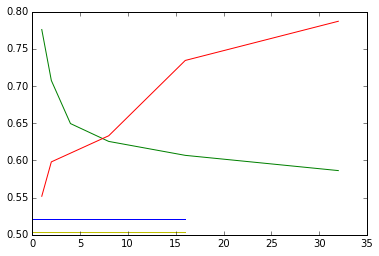

DT
32
0.787009947338


In [85]:
feature = 'unix_timestamp_of_request_utc'

print feature + "\n"
train_data_plus_5, cv_data_plus_5, test_data_plus_5 = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus_4, cv_up, cv_up_labels, cv_data_plus_4, test_up, test_up_labels, test_data_plus_4, feature)

### Code added to test length of text

In [86]:
for entry in train_up:
    entry['length_of_text'] = len(entry['request_text_edit_aware'].split())    
    
for entry in cv_up:
    entry['length_of_text'] = len(entry['request_text_edit_aware'].split())        
    
for entry in test_up:
    entry['length_of_text'] = len(entry['request_text_edit_aware'].split())        


length_of_text


The cv stats for LR with C=0.0001
             precision    recall  f1-score   support

        0.0       0.49      1.00      0.66       840
        1.0       0.00      0.00      0.00       870

avg / total       0.24      0.49      0.32      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67       862
        1.0       0.00      0.00      0.00       847

avg / total       0.25      0.50      0.34      1709


The cv stats for BNB with alpha=0.0001
             precision    recall  f1-score   support

        0.0       0.52      0.88      0.65       840
        1.0       0.64      0.20      0.30       870

avg / total       0.58      0.54      0.48      1710

The test results are:

             precision    recall  f1-score   support

        0.0       0.52      0.85      0.65       862
        1.0       0.57      0.19      0.29       847

avg / total       0.54      0.53      0.47      1709


Th

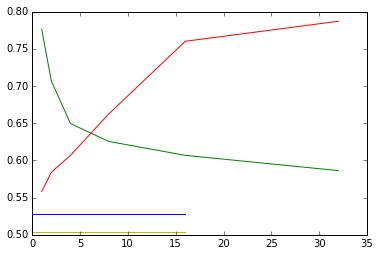

DT
32
0.787009947338


In [87]:
feature = 'length_of_text'

print feature + "\n"
train_data_plus_5, cv_data_plus_5, test_data_plus_5 = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus_5, cv_up, cv_up_labels, cv_data_plus_5, test_up, test_up_labels, test_data_plus_5, feature)

In [94]:
train_up[0]

{'activity_level': 0.192459250540512,
 u'giver_username_if_known': u'N/A',
 u'in_test_set': True,
 'length_of_text': 79,
 'length_of_title': 4,
 'length_of_username': 9,
 u'number_of_downvotes_of_request_at_retrieval': 0,
 u'number_of_upvotes_of_request_at_retrieval': 1,
 u'post_was_edited': False,
 u'request_id': u't3_kwrjo',
 u'request_number_of_comments_at_retrieval': 0,
 u'request_text': u'My bf. \n\nHe finishes work at 9pm and I think he would be really chuffed if he came home to a RAoP (I think he deserves it). Just thinking about how happy his (rather attractive) face would be is making me smile lots and lots. \n\nHe is in love with Reddit forevz and would likely reimburse you with a witty song or nice picture of something bad ass.\n\nThanks for reading, I hope you might like to help ;)',
 u'request_text_edit_aware': u'My bf. \n\nHe finishes work at 9pm and I think he would be really chuffed if he came home to a RAoP (I think he deserves it). Just thinking about how happy his (r

### Add feature length of text and user name finished

For text we have this many features: 2204

 For the title we have this many features :2264
request_text_edit_aware

For KNN cv :

             precision    recall  f1-score   support

        0.0       0.66      0.75      0.70       840
        1.0       0.72      0.63      0.67       870

avg / total       0.69      0.69      0.69      1710

For KNN test :

             precision    recall  f1-score   support

        0.0       0.68      0.77      0.72       862
        1.0       0.73      0.62      0.67       847

avg / total       0.70      0.70      0.70      1709

request_title

For KNN cv :

             precision    recall  f1-score   support

        0.0       0.69      0.84      0.76       840
        1.0       0.81      0.63      0.71       870

avg / total       0.75      0.74      0.73      1710

For KNN test :

             precision    recall  f1-score   support

        0.0       0.68      0.82      0.74       862
        1.0       0.77      0.60      0.67       847

avg

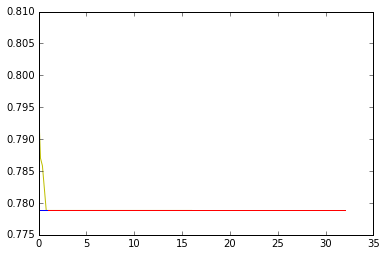

LR
0.01
0.809830310123


In [90]:
#make four models (one from title, test, subreddit, and numerical) and see if ensemble is better

print "For text we have this many features: " + str(len(ValuableVocab_Text[4]))
print "\n For the title we have this many features :" + str(len(ValuableVocab_Title[5]))

#get the data again

train_data_text = []
cv_data_text = []
test_data_text = []
train_data_title = []
cv_data_title = []
test_data_title = []
train_data_sr = []
cv_data_sr = []
test_data_sr = []
    
feature = 'request_text_edit_aware'    
for i in range(len(train_up_labels)):
    train_data_text.append(train_up[i].get(feature))

for i in range(len(cv_up_labels)):
    cv_data_text.append(cv_up[i].get(feature))

for i in range(len(test_up_labels)):
    test_data_text.append(test_up[i].get(feature))

feature = 'request_title'    
for i in range(len(train_up_labels)):
    train_data_title.append(train_up[i].get(feature))

for i in range(len(cv_up_labels)):
    cv_data_title.append(cv_up[i].get(feature))

for i in range(len(test_up_labels)):
    test_data_title.append(test_up[i].get(feature))

feature = 'requester_subreddits_at_request'
for i in range(len(train_up_labels)):
    train_data_sr.append(string.join(train_up[i].get(feature)," "))
for i in range(len(cv_up_labels)):
    cv_data_sr.append(string.join(cv_up[i].get(feature)," "))
for i in range(len(test_up_labels)):
    test_data_sr.append(string.join(test_up[i].get(feature)," "))    

#vectorize the title with the right number of features
vec_train_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_train_data_title = vec_train_title.fit_transform(train_data_title)

vec_cv_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_cv_data_title = vec_cv_title.fit_transform(cv_data_title)

vec_test_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_test_data_title = vec_test_title.fit_transform(test_data_title)

#vectorize the text with the right number of features

vec_train_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_train_data_text = vec_train_text.fit_transform(train_data_text)

vec_cv_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_cv_data_text = vec_cv_text.fit_transform(cv_data_text)

vec_test_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_test_data_text = vec_test_text.fit_transform(test_data_text)

#vectorize the subreddits with the right number of features

vec_train_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_train_data_sr = vec_train_sr.fit_transform(train_data_sr)

vec_cv_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_cv_data_sr = vec_cv_sr.fit_transform(cv_data_sr)

vec_test_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_test_data_sr = vec_test_sr.fit_transform(test_data_sr)


######REQUEST TEXT EDIT AWARE#######
feature = 'request_text_edit_aware'
print feature + "\n"

KNN_train_text = KNeighborsClassifier(n_neighbors = 2)
KNN_train_text.fit(tokenized_train_data_text,train_up_labels)

cv_pred = KNN_train_text.predict(tokenized_cv_data_text)

print "For KNN cv :\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = KNN_train_text.predict(tokenized_test_data_text)

print "For KNN test :\n"
print(classification_report(test_up_labels, test_pred))


######REQUEST TITLE#######
feature = 'request_title'
print feature + "\n"

KNN_train_title = KNeighborsClassifier(n_neighbors = 2)
KNN_train_title.fit(tokenized_train_data_title,train_up_labels)

cv_pred = KNN_train_title.predict(tokenized_cv_data_title)

print "For KNN cv :\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = KNN_train_title.predict(tokenized_test_data_title)

print "For KNN test :\n"
print(classification_report(test_up_labels, test_pred))
    
######SUBREDDITS SUBSCRIBED#########

feature = 'requester_subreddits_at_request'
print feature + "\n"

LR_train_subreddit = LogisticRegression(C = 8)
LR_train_subreddit.fit(tokenized_train_data_sr,train_up_labels)

cv_pred = LR_train_subreddit.predict(tokenized_cv_data_sr)

print "For LR cv :\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = LR_train_subreddit.predict(tokenized_test_data_sr)

print "For LR test :\n"
print(classification_report(test_up_labels, test_pred))


#######NUMERICAL PROPERTIES#########
clf = DecisionTreeClassifier(max_depth=32)
clf.fit(train_data_plus_5,train_up_labels)

cv_pred = clf.predict(cv_data_plus_5)

print "\nFor DT cv with max depth of 32:\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = clf.predict(test_data_plus_5)

print "The test results are:\n"
print(classification_report(test_up_labels, test_pred))

#####ENSEMBLE VIA PROBABILITY #######

train_text_probability = KNN_train_text.predict_proba(tokenized_train_data_text)
cv_text_probability = KNN_train_text.predict_proba(tokenized_cv_data_text)
test_text_probability = KNN_train_text.predict_proba(tokenized_test_data_text)
train_title_probability = KNN_train_title.predict_proba(tokenized_train_data_title)
cv_title_probability = KNN_train_title.predict_proba(tokenized_cv_data_title)
test_title_probability = KNN_train_title.predict_proba(tokenized_test_data_title)
train_sr_probability = LR_train_subreddit.predict_proba(tokenized_train_data_sr)
cv_sr_probability = LR_train_subreddit.predict_proba(tokenized_cv_data_sr)
test_sr_probability = LR_train_subreddit.predict_proba(tokenized_test_data_sr)
train_num_probability = clf.predict_proba(train_data_plus_5)
cv_num_probability = clf.predict_proba(cv_data_plus_5)
test_num_probability = clf.predict_proba(test_data_plus_5)

train_ensemble_prob = np.c_[train_text_probability,train_title_probability,
                                 train_sr_probability,train_num_probability]
cv_ensemble_prob = np.c_[cv_text_probability,cv_title_probability,
                              cv_sr_probability,cv_num_probability]
test_ensemble_prob = np.c_[test_text_probability,test_title_probability,
                                test_sr_probability,test_num_probability]

print "Ensemble models!!!\n\n"

best_clf, best_config, best_score = find_optim_model_numerical(train_ensemble_prob, 
                           train_up_labels, cv_ensemble_prob, cv_up_labels, 
                           test_ensemble_prob, test_up_labels)

print best_clf
print best_config
print best_score

In [93]:
#create predictions for Kaggle
#order of data:
#text stuff
#requester_account_age_in_days_at_request
#requester_days_since_first_post_on_raop_at_request
#requester_number_of_comments_at_request
#requester_upvotes_minus_downvotes_at_request
#requester_number_of_subreddits_at_request
#unix_timestamp_of_request_utc
#hyperlink exist

#READ

test_data = pd.read_json('data/test.json')
test_data_text = test_data.request_text_edit_aware
test_data_title = test_data.request_title
test_data_subreddits = test_data.requester_subreddits_at_request

test_data_age = test_data.requester_account_age_in_days_at_request
test_data_days = test_data.requester_days_since_first_post_on_raop_at_request
test_data_comm = test_data.requester_number_of_comments_at_request
test_data_umd = test_data.requester_upvotes_minus_downvotes_at_request
test_data_sub = test_data.requester_number_of_subreddits_at_request
test_data_utc = test_data.unix_timestamp_of_request_utc
test_data_length_of_text = [len(entry.split()) for entry in test_data.request_text_edit_aware.values]

#TOKENIZE
vec_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_test_data_text = vec_text.fit_transform(test_data_text)

vec_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_test_data_title = vec_title.fit_transform(test_data_title)

st_tmp = []

for i in range(len(test_data_subreddits)):
    st_tmp.append(string.join(test_data_subreddits[i]," "))

vec_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_test_data_sr = vec_sr.fit_transform(st_tmp)

#AGG NUMERICAL FEATURES
num_feat = np.c_[test_data_age, test_data_days, test_data_comm, test_data_umd, test_data_sub, test_data_utc, 
                test_data_length_of_text]

#PREDICT
text_prob = KNN_train_text.predict_proba(tokenized_test_data_text)
title_prob = KNN_train_title.predict_proba(tokenized_test_data_title)
sr_prob = LR_train_subreddit.predict_proba(tokenized_test_data_sr)
num_prob = clf.predict_proba(num_feat)

submission_ensemble_prob = np.c_[text_prob, title_prob, sr_prob, num_prob]

LR_ensemble_submit = LogisticRegression(C=0.001)
LR_ensemble_submit.fit(train_ensemble_prob,train_up_labels)

test_pred = LR_ensemble_submit.predict(submission_ensemble_prob)


#OUTPUT
predictions = pd.DataFrame()
predictions['request_id'] = test_data.request_id
predictions['requester_received_pizza'] = test_pred
predictions = predictions.set_index('request_id')

predictions.to_csv('NLP_submission_v8_upsample_alltext_allnum_ensemble_preproc.csv')